# Machine Learning Models

The goal is to try to predict runtime specifically in seconds, based on input data to burnpro

## Setup and Preprocessing

In [440]:
# pip install any necessary package

In [479]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt

Read the dataset in from the csv and drop the index column

In [480]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,1934680,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,2470180,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,517424,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,2454040,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,3919432,648024.0,600


Now let's try to make some models and see what we can do!

Normalize all the values to make them better suited for ML models, maybe in future trials a StandardScaler might give good results

In [481]:
for column in df.columns:
    if column != "runtime":
        df[column] = normalize(df[column])

y = df["runtime"]

X = df.drop(columns=["runtime"])
pred = {}
models = {}

In [482]:
df

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,1934680,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,2470180,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,517424,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,2454040,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,3919432,648024.0,600
...,...,...,...,...,...,...,...,...,...,...
1562,526,4005,0.10,600,60.0,2.235,0.90,401132,294840.0,600
1563,8858,11359,0.05,600,150.0,4.023,1.00,2470680,1981888.0,600
1564,577,3937,0.07,600,240.0,2.235,0.95,517488,359488.0,600
1565,11663,27251,0.15,600,60.0,4.470,0.90,3920324,648024.0,600


Split datasets into test and train, and define handy functions for later

TEST_RATIO = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

In [483]:
def print_score(pred, true):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(true, pred),5))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(true, pred),5))
    
def to_time_str(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(to_time_str(predictions[i]), "\t",to_time_str(int(y_test[i])), "\t", to_time_str(y_test[i] - predictions[i]))

def show_plots(predictions, y_test, s=4):
    plt.subplot(211) 
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.ylim([0,50000])
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

Some handy functions for later

Now that the training data is all configured, lets run different models on it and see how they compare in their loss

# K Means Clustering

In [484]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [485]:
# ------ experiment with cluster amount ---------- #
n_clusters = 10
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [486]:
prediction = model.predict(X_test)

In [487]:
prediction_mapping = (prediction / n_clusters) * y_test.max()
results = pd.DataFrame({
    "prediction": prediction_mapping,
    "answer":y_test,
    "difference": y_test-prediction_mapping
})
results.head(4)

,prediction,answer,difference
0,26944.0,1567,-25377.0
1,48499.2,11449,-37050.2
2,26944.0,2287,-24657.0
3,0.0,592,592.0


In [488]:
pred["kMeans"] = model.predict(X_test)
models["kMeans"] = model
print_score(prediction, y_test)

Mean Squared Error:    86452050.70276
Mean Absolute Error:   6428.09979


### Now let's try for many values of k

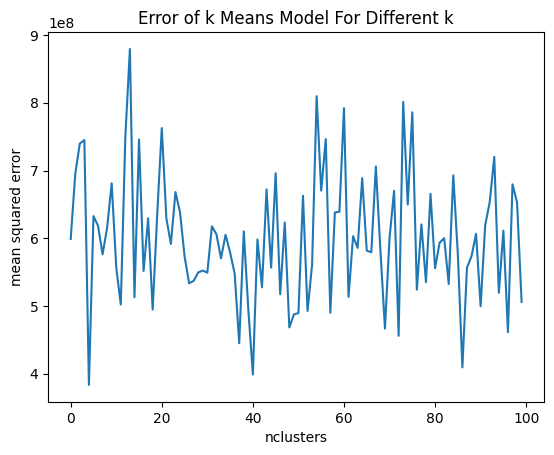

In [489]:
def get_mse(n_clusters):
    global X_test, y_test, X_train, y_train
    n_clusters = 30
    model = KMeans(n_clusters=n_clusters, n_init='auto')
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    
    prediction_mapping = (prediction / n_clusters) * y_test.max()
    return mean_squared_error(y_true=y_test, y_pred=prediction_mapping)

get_mse(30)
clusters = list(range(0,100))
MSE = []
for i in clusters:
    MSE.append(round(get_mse(i),2))

plt.title("Error of k Means Model For Different k")
plt.xlabel("nclusters")
plt.ylabel("mean squared error")
plt.plot(clusters,MSE)
plt.show()

so it looks like K means clustering has a long way to go and more clusters has no real effect on the accuracy. Let's try some other methods

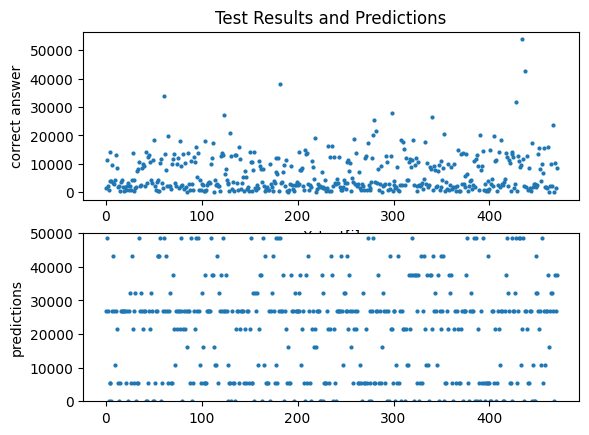

In [490]:
show_plots(prediction_mapping,y_test)

These graphs ideally would match up exactly, but they look vastly different, so it seems K means isn't sophisticated enough for this problem. That is not surprising given the quantity of numerical data

# Multi Linear Regression

In [491]:
import numpy as np

In [492]:
model = LinearRegression()
model = model.fit(X_train,y_train)

In [493]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    86506882.23687
Mean Absolute Error:   6431.90406


In [494]:
pred["multi-linear"] = model.predict(X_test)
models["multi-linear"] = model
print_score(predictions, y_test)

Mean Squared Error:    86506882.23687
Mean Absolute Error:   6431.90406


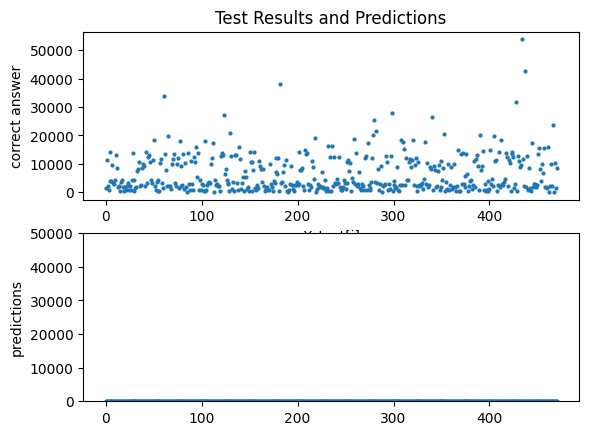

In [495]:
show_plots(predictions,y_test,s=4)

# Neural Net

In [496]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

y_train = normalize(y_train)

In [497]:
# example of training a final regression model
from keras.models import Sequential
from keras.layers import Dense

# generate regression dataset
X, y = make_regression(n_samples=100, n_features=9, noise=0.1, random_state=1)
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X)
scalarY.fit(y.reshape(100,1))
X = scalarX.transform(X)
y = scalarY.transform(y.reshape(100,1))

# define and fit the final model
model = Sequential()
model.add(Dense(9, input_shape=(9,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
h = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split = 0.1)

# CHANGE LAST LAYER

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0142
Epoch 2/100
31/31 [==============================] - 0s 966us/step - loss: 0.0139 - val_loss: 0.0124
Epoch 3/100
31/31 [==============================] - 0s 941us/step - loss: 0.0117 - val_loss: 0.0108
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 5/100
31/31 [==============================] - 0s 891us/step - loss: 0.0084 - val_loss: 0.0072
Epoch 6/100
31/31 [==============================] - 0s 921us/step - loss: 0.0076 - val_loss: 0.0061
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 8/100
31/31 [==============================] - 0s 879us/step - loss: 0.0067 - val_loss: 0.0055
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 10/100
31/31 [==============================] - 0s 873us/step - loss: 0.0061 - val_loss: 0.00

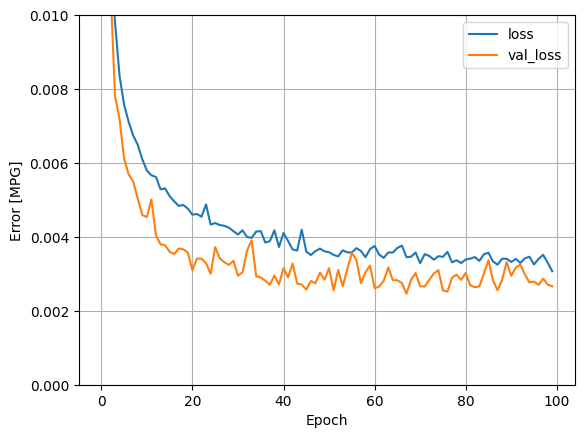

In [498]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1e-2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(h)

In [499]:
predictions = model.predict(X_test, verbose=0)
print_score(predictions, y_test)

# Mean Squared Error:    0.03558335327632717
# Mean Absolute Error:   0.16927700703786802

Mean Squared Error:    86506561.892
Mean Absolute Error:   6431.89744


In [500]:
pred["keras"] = model.predict(X_test)
models["keras"] = model
print_score(predictions, y_test)

15/15 [==============================] - 0s 344us/step
Mean Squared Error:    86506561.892
Mean Absolute Error:   6431.89744


In [501]:
print_score(predictions,y_test)

Mean Squared Error:    86506561.892
Mean Absolute Error:   6431.89744


In [502]:

# Mean Squared Error:    86506857.70903887
# Mean Absolute Error:   6431.912279610207

# Mean Squared Error:    86506687.77386706
# Mean Absolute Error:   6431.89729009321

# Mean Squared Error:    86506881.56282507
# Mean Absolute Error:   6431.909780053204

# Mean Squared Error:    86506690.3881022
# Mean Absolute Error:   6431.898311441057

# Mean Squared Error:    86506774.30611314
# Mean Absolute Error:   6431.903274915572


# SVM

In [503]:
model = SVR(kernel='rbf')
model = model.fit(X_train,y_train)

/root/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [504]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    86506616.47815
Mean Absolute Error:   6431.89298


In [505]:
pred["SVM"] = model.predict(X_test)
models["SVM"] = model
print_score(predictions, y_test)

Mean Squared Error:    86506616.47815
Mean Absolute Error:   6431.89298


In [506]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
a day 	 26 minutes 	 26 minutes
a moment 	 3 hours 	 3 hours
a moment 	 38 minutes 	 38 minutes
a day 	 9 minutes 	 9 minutes
a moment 	 3 hours 	 3 hours
a moment 	 an hour 	 an hour
a moment 	 an hour 	 an hour
a moment 	 2 hours 	 2 hours
a moment 	 51 minutes 	 51 minutes
a moment 	 45 minutes 	 45 minutes
a moment 	 an hour 	 an hour
a moment 	 3 hours 	 3 hours
a moment 	 2 hours 	 2 hours
a moment 	 27 minutes 	 27 minutes
a moment 	 35 minutes 	 35 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 56 minutes 	 56 minutes
a moment 	 an hour 	 an hour
a moment 	 32 minutes 	 32 minutes
a day 	 8 minutes 	 8 minutes
a moment 	 30 minutes 	 30 minutes
a moment 	 13 minutes 	 13 minutes
a moment 	 33 minutes 	 33 minutes
a moment 	 54 minutes 	 54 minutes
a day 	 12 minutes 	 12 minutes


seems like this only predicts something like the best guess of the dataset, not actually doing much prediction

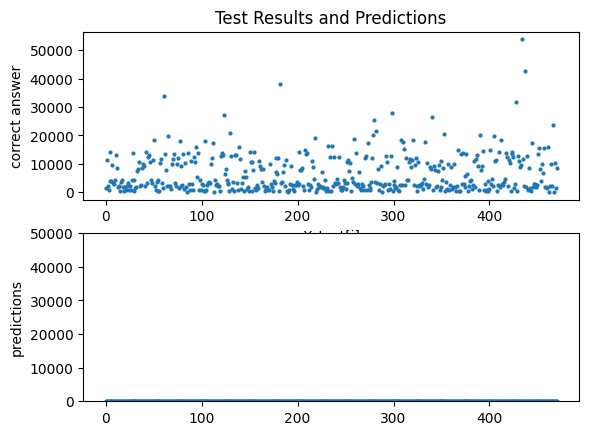

In [507]:
show_plots(predictions,y_test)

# Decision Trees

In [508]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model = model.fit(X_train, y_train)

In [509]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    86506823.3563
Mean Absolute Error:   6431.90996


In [510]:
pred["DecisionTree"] = model.predict(X_test)
models["DecisionTree"] = model
print_score(predictions, y_test)

Mean Squared Error:    86506823.3563
Mean Absolute Error:   6431.90996


In [511]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
a moment 	 26 minutes 	 26 minutes
a moment 	 3 hours 	 3 hours
a moment 	 38 minutes 	 38 minutes
a moment 	 9 minutes 	 9 minutes
a moment 	 3 hours 	 3 hours
a moment 	 an hour 	 an hour
a moment 	 an hour 	 an hour
a moment 	 2 hours 	 2 hours
a moment 	 51 minutes 	 51 minutes
a moment 	 45 minutes 	 45 minutes
a moment 	 an hour 	 an hour
a moment 	 3 hours 	 3 hours
a moment 	 2 hours 	 2 hours
a moment 	 27 minutes 	 27 minutes
a moment 	 35 minutes 	 35 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 56 minutes 	 56 minutes
a moment 	 an hour 	 an hour
a moment 	 32 minutes 	 32 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 30 minutes 	 30 minutes
a moment 	 13 minutes 	 13 minutes
a moment 	 33 minutes 	 33 minutes
a moment 	 54 minutes 	 54 minutes
a moment 	 12 minutes 	 12 minutes


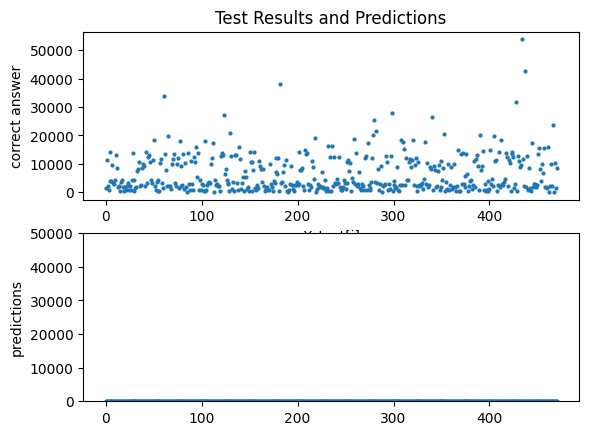

In [512]:
show_plots(predictions,y_test)

# Compare Plots

In [513]:
# compare = pd.DataFrame(pred)
compare = pd.DataFrame({
    "name":pred.keys(), 
    "mean absolute":np.nan,
    "mse":np.nan,
})
compare = compare.set_index("name")

In [514]:
# compare["accuracy"] = compare.apply(lambda row: accuracy_score(y_pred=pred[row.name],y_true=y_test)*100,axis=1)
compare["mse"] = compare.apply(lambda row: mean_squared_error(y_pred=pred[row.name],y_true=y_test),axis=1)
compare["mean absolute"] = compare.apply(lambda row: mean_absolute_error(y_pred=pred[row.name],y_true=y_test),axis=1)

In [515]:
compare.sort_values(by='mean absolute',ascending=True)

,mean absolute,mse
name,,
kMeans,6428.099788,8.645205e+07
SVM,6431.892981,8.650662e+07
keras,6431.897440,8.650656e+07
multi-linear,6431.904062,8.650688e+07
DecisionTree,6431.909955,8.650682e+07


So it seems the multi linear model seems to be the best by far. Still not the most favorable results, cause 2300 seconds is about 40 min off, lets try this as a classification problem now

In [516]:
to_time_str(2400)

'40 minutes'